## Initialization

In [ ]:
kaggle = False

### Mount drive

In [ ]:
from google.colab import drive
if not kaggle:
  drive.mount('/gdrive', force_remount=True)
  
  !rm -rf /content/data_orig
  !cp -r "/gdrive/My Drive/ANN challenges/data" "/content/data_orig"

Mounted at /gdrive


### Import libraries

In [ ]:
# there is a bug for efficientnet in 2.10.0
# that does not allow to save the model
# !pip install tensorflow==2.10.0
!pip install tensorflow==2.9.2
!pip install Cython==0.29.32
!pip install numpy==1.21.6
!pip install matplotlib==3.2.2
!pip install seaborn==0.11.2
!pip install scipy==1.7.3
!pip install scikit-learn==1.0.2
!pip install scikit-image==0.18.3
!pip install pandas==1.3.5
!pip install pyyaml==6.0
!pip install imutils==0.5.4
!pip install opencv-python==4.6.0.66
!pip install tqdm==4.64.1
!pip install psutil==5.4.8
!pip install h5py==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

In [ ]:
import os
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

keras = tf.keras
layers = tf.keras.layers
tf.__version__

'2.9.2'

In [ ]:
!pip install keras-cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn as sns
import keras_cv

### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Parameters

In [ ]:
# batch size used for training
batch_size = 8

# number of elements for each class of the validation set
split_entries = [10, 45, 45, 45, 45, 20, 45, 20]

# final number of elements for each training class after oversampling
train_entries = 1000

### Augmentation

In [ ]:
# Apply multiple random augmentation filter on the given image
# Used for dataset oversampling
def apply_data_augmentation(image):
  image = tf.image.random_brightness(image, 0.2, seed=seed)
  image = tf.image.random_jpeg_quality(image, 70, 100, seed=seed)
  image = tf.image.random_contrast(image, 0.8, 1.2, seed=seed)
  image = tf.image.random_flip_left_right(image, seed=seed)
  image = tf.image.random_flip_up_down(image, seed=seed)
  image = tf.image.random_saturation(image, 0.8, 1.2, seed=seed)
  image = tf.image.random_hue(image, 0.2, seed=seed)
  return image

### Model

In [ ]:
# regularizer = keras.regularizers.L2(0.01)
regularizer = None

# initializer = keras.initializers.HeUniform(seed)
initializer = keras.initializers.GlorotUniform(seed)

optimizer = keras.optimizers.Adam(0.01)
ft_optimizer = keras.optimizers.Adam(0.01)

In [ ]:
preprocess_function = keras.applications.efficientnet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False,
    weights="imagenet",
    input_shape = (96,96,3)
)

## Oversampling

### Define utilities

In [ ]:
# Return number of total items and a list of occurences for each class in the given dataset
# ! It works only with unbatched datasets
def count_occurences(ds):
  count = 0
  occ = [0, 0, 0, 0, 0, 0, 0, 0]

  for x, y in ds:
      image, label = extract_image_and_label(x, y)
      occ[label] += 1
      count += 1
  return count, occ

In [ ]:
# Print information about the training and validation set
def get_dataset_details(ds, name="train_ds"):
  ds_count, ds_occ = count_occurences(ds)

  classes = []
  for i in range(8):
    classes.append(ds_occ[i])

  name = name.ljust(20)
  print(name, "Batches: %4d \t Total images: %5d \t Classes: " % (ds.cardinality().numpy(), ds_count), classes)

In [ ]:
# Create base directory structure for a dataset
def create_directories(base_path):
  os.mkdir(base_path + "/Species1")
  os.mkdir(base_path + "/Species2")
  os.mkdir(base_path + "/Species3")
  os.mkdir(base_path + "/Species4")
  os.mkdir(base_path + "/Species5")
  os.mkdir(base_path + "/Species6")
  os.mkdir(base_path + "/Species7")
  os.mkdir(base_path + "/Species8")

In [ ]:
# Extract label and image from a tensor
def extract_image_and_label(image, label):
  image = image.numpy().astype("uint8")
  lb_ohe = label.numpy()
  label = np.where(lb_ohe==1)[0][0]
  return image, label

In [ ]:
# Generate in base_path an augmented set to balance all classes to the given goal
def generate_images(ds, base_path, goal_number):
  ids = [1, 1, 1, 1, 1, 1, 1, 1]
  os.mkdir(base_path)
  create_directories(base_path)
  elems, train_occ = count_occurences(ds)

  # calculate classes with a very small number of items
  minority_classes = {}
  for i in range(8):
    if train_occ[i] * 2 < goal_number:
      minority_classes[i] = goal_number / train_occ[i]

  # make each set of the same number of images by using data augmentation
  for x, y in ds:
      image, label = extract_image_and_label(x, y)

      image_path = base_path + "/Species%d/%.5d" % (label + 1, ids[label])
      ids[label] += 1

      path = image_path + ".jpg"
      keras.utils.save_img(path, image)

      # images of minority classes are augmented multiple times
      if label in minority_classes:
        j = 0
        while(j < minority_classes[label] and train_occ[label] < goal_number):
          path = image_path + "_aug_%.2d.jpg" % (j + 1)
          image = apply_data_augmentation(image)
          keras.utils.save_img(path, image)

          train_occ[label] += 1
          j += 1
      # otherwise only one augmentation is enough
      elif train_occ[label] < goal_number:
        path = image_path + "_aug.jpg"
        image = apply_data_augmentation(image)
        keras.utils.save_img(path, image)

        train_occ[label] += 1

In [ ]:
# Save the given dataset, useful for validation set
def save_ds(ds, base_path):
  ids = [1, 1, 1, 1, 1, 1, 1, 1]
  os.mkdir(base_path)
  create_directories(base_path)

  for x, y in ds:
    image, label = extract_image_and_label(x, y)
    path = base_path + "/Species%d/%.5d.jpg" % (label + 1, ids[label])
    keras.utils.save_img(path, image)
    ids[label] += 1

### Split the original dataset

In [ ]:
# split the given dataset in training and validation with split_entries for each class of the validation set
def custom_dataset_split(ds, split_entries):
  base_path = "data_splitted"
  ids = [1, 1, 1, 1, 1, 1, 1, 1]
  val_ds = [0, 0, 0, 0, 0, 0, 0, 0]
  
  os.system("rm -rf " + base_path)
  os.mkdir(base_path)

  train_path = base_path + "/train"
  os.mkdir(train_path)
  create_directories(train_path)

  val_path = base_path + "/val"
  os.mkdir(val_path)
  create_directories(val_path)
  
  for x, y in ds:
      image, label = extract_image_and_label(x, y)

      if val_ds[label] < split_entries[label]:
        path = val_path
        val_ds[label] += 1
      else:
        path = train_path

      path += "/Species%d/%.5d.jpg" % (label + 1, ids[label])
      keras.utils.save_img(path, image)
      ids[label] += 1

In [ ]:
orig_ds_dir = 'data_orig'

if kaggle:
  orig_ds_dir = '../input/ann-challenge-1-poli-neurons/training_data_final'

In [ ]:
orig_ds = keras.utils.image_dataset_from_directory(
      orig_ds_dir,
      batch_size=None,
      seed=seed,
      shuffle=True,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False
)

Found 3542 files belonging to 8 classes.


In [ ]:
custom_dataset_split(orig_ds, split_entries)

### Import the splitted dataset

In [ ]:
split_ds_dir = 'data_splitted'
train_dir = split_ds_dir + "/train"
val_dir = split_ds_dir + "/val"

In [ ]:
train_ds  = keras.utils.image_dataset_from_directory(
      train_dir,
      batch_size=None,
      seed=seed,
      shuffle=True,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False,
)

Found 3267 files belonging to 8 classes.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
      val_dir,
      batch_size=None,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False,
)

Found 275 files belonging to 8 classes.


In [ ]:
get_dataset_details(train_ds)
get_dataset_details(val_ds, name="val_ds")

train_ds             Batches: 3267 	 Total images:  3267 	 Classes:  [176, 487, 470, 466, 486, 202, 492, 488]
val_ds               Batches:  275 	 Total images:   275 	 Classes:  [10, 45, 45, 45, 45, 20, 45, 20]


### Examples of filters

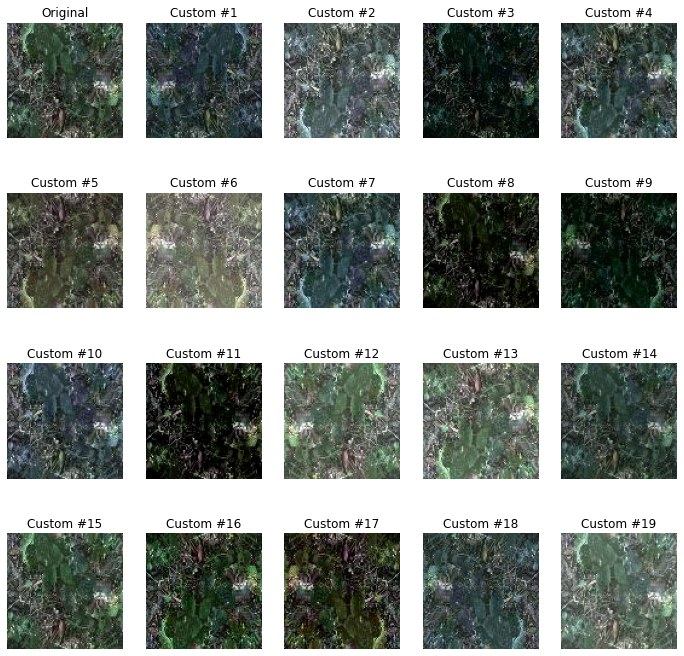

In [ ]:
# read one image
for x, y in train_ds:
  image, label = extract_image_and_label(x, y)
  original = image
  break

plt.figure(figsize=(12, 12))
for i in range(20):
    image, label = extract_image_and_label(x, y)
    ax = plt.subplot(4, 5, i + 1)
    if i == 0:
      plt.imshow(original)
      plt.title("Original")
    else:
      plt.imshow(apply_data_augmentation(original))
      plt.title("Custom #%d" % i)
    plt.axis("off")

### Generate augmented images

In [ ]:
aug_data_dir = "data_%d" % train_entries

In [ ]:
# clean folder
os.system("rm -rf " + aug_data_dir)
os.mkdir(aug_data_dir)

In [ ]:
generate_images(train_ds, aug_data_dir + "/train", train_entries)

In [ ]:
save_ds(val_ds, aug_data_dir + "/val")

### Check results

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
      aug_data_dir + "/train",
      batch_size=None,
      seed=seed,
      shuffle=True,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False
)

Found 8000 files belonging to 8 classes.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
      aug_data_dir + "/val",
      batch_size=None,
      seed=seed,
      shuffle=False,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False
)

Found 275 files belonging to 8 classes.


In [ ]:
get_dataset_details(train_ds)
get_dataset_details(val_ds, name="val_ds")

train_ds             Batches: 8000 	 Total images:  8000 	 Classes:  [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
val_ds               Batches:  275 	 Total images:   275 	 Classes:  [10, 45, 45, 45, 45, 20, 45, 20]


## Model

### Define utilities

In [ ]:
import zipfile

def zip_folder(folder='model'):
    zipf = zipfile.ZipFile(folder + '.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir(folder, zipf)
    zipf.close()

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))


In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_callbacks(patience=10):

  callbacks = []

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
labels = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

def plot_confusion_matrix(dataset, ds_type):
  actual = []
  predicted = []
  for x,y in dataset:
    y= tf.argmax(y,axis=1)
    actual.append(y)
    predicted.append(tf.argmax(model.predict(x, verbose=0),axis = 1))
    
  predicted = tf.concat(predicted, axis=0)
  actual = tf.concat(actual, axis=0)

  cm = tf.math.confusion_matrix(actual, predicted, num_classes=8)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
def pretty_print_results(model, train_ds, val_ds):
  train_res = model.evaluate(train_ds)
  val_res = model.evaluate(val_ds)
  print("%.4f %.4f %.4f %.4f" % (train_res[0], train_res[1], val_res[0], val_res[1]))
  return train_res, val_res

### Import the augmented dataset

In [ ]:
dataset_dir = aug_data_dir
train_dir = dataset_dir + "/train"
val_dir = dataset_dir + "/val"

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
      train_dir,
      batch_size=batch_size,
      seed=seed,
      shuffle=True,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False
)

Found 8000 files belonging to 8 classes.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
      val_dir,
      batch_size=batch_size,
      seed=seed,
      shuffle=False,
      image_size=(96, 96),
      labels='inferred',
      label_mode='categorical',
      class_names=None,
      color_mode='rgb',
      interpolation='bilinear',
      follow_links=False,
      crop_to_aspect_ratio=False
)

Found 275 files belonging to 8 classes.



### Models metadata

In [ ]:
input_shape = (96, 96, 3)

### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Define the model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(96, 96),
  layers.Rescaling(1./255)
], "resize_and_rescale_layer")

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=seed),
  layers.RandomRotation(0.4, seed=seed),
  layers.RandomZoom(0.3, seed=seed),
], "data_augmentation_layer")

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()

inputs = keras.Input(shape=input_shape, name="input")

x = preprocess_function(inputs)

base_model.trainable = False

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization(name="top_batch_normalization")(x)
x = layers.Dropout(0.75, name="top_dropout", seed=seed)(x)

outputs = layers.Dense(8, activation='softmax', name='output_layer', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.build(input_shape)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_batch_normalization (Ba  (None, 1280)             5120      
 tchNormalization)                                               
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                           

### Train the model

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-2), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(
    x = train_ds,
    epochs = 100,
    validation_data = val_ds,
    callbacks = create_callbacks(patience=10)
)

Epoch 1/100
1000/1000 [==============================] - 31s 23ms/step - loss: 5.5131 - accuracy: 0.3645 - val_loss: 1.5118 - val_accuracy: 0.6655
Epoch 2/100
1000/1000 [==============================] - 16s 16ms/step - loss: 2.9336 - accuracy: 0.3931 - val_loss: 0.9455 - val_accuracy: 0.6509
Epoch 3/100
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8883 - accuracy: 0.4090 - val_loss: 1.0140 - val_accuracy: 0.6145
Epoch 4/100
1000/1000 [==============================] - 14s 14ms/step - loss: 2.0012 - accuracy: 0.3850 - val_loss: 1.0640 - val_accuracy: 0.6073
Epoch 5/100
1000/1000 [==============================] - 14s 14ms/step - loss: 2.2268 - accuracy: 0.3661 - val_loss: 1.2262 - val_accuracy: 0.5491
Epoch 6/100
1000/1000 [==============================] - 14s 14ms/step - loss: 2.3535 - accuracy: 0.3568 - val_loss: 1.1229 - val_accuracy: 0.5600
Epoch 7/100
1000/1000 [==============================] - 14s 14ms/step - loss: 2.4168 - accuracy: 0.3537 - val_loss: 1

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(
    x = train_ds,
    epochs = 100,
    validation_data = val_ds,
    callbacks = create_callbacks(patience=10)
)

Epoch 1/100
1000/1000 [==============================] - 23s 17ms/step - loss: 3.3639 - accuracy: 0.4386 - val_loss: 1.1160 - val_accuracy: 0.6945
Epoch 2/100
1000/1000 [==============================] - 15s 15ms/step - loss: 2.6361 - accuracy: 0.4516 - val_loss: 0.9368 - val_accuracy: 0.7164
Epoch 3/100
1000/1000 [==============================] - 15s 15ms/step - loss: 2.1269 - accuracy: 0.4696 - val_loss: 0.8661 - val_accuracy: 0.7273
Epoch 4/100
1000/1000 [==============================] - 14s 14ms/step - loss: 1.7716 - accuracy: 0.4930 - val_loss: 0.8129 - val_accuracy: 0.7382
Epoch 5/100
1000/1000 [==============================] - 15s 15ms/step - loss: 1.5842 - accuracy: 0.4971 - val_loss: 0.8286 - val_accuracy: 0.7345
Epoch 6/100
1000/1000 [==============================] - 14s 14ms/step - loss: 1.4638 - accuracy: 0.5150 - val_loss: 0.8064 - val_accuracy: 0.7273
Epoch 7/100
1000/1000 [==============================] - 14s 14ms/step - loss: 1.3638 - accuracy: 0.5226 - val_loss: 0

### See results

In [ ]:
tl_res = pretty_print_results(model, train_ds, val_ds)

35/35 [==============================] - 0s 12ms/step - loss: 0.8301 - accuracy: 0.7636
0.8972 0.7103 0.8301 0.7636


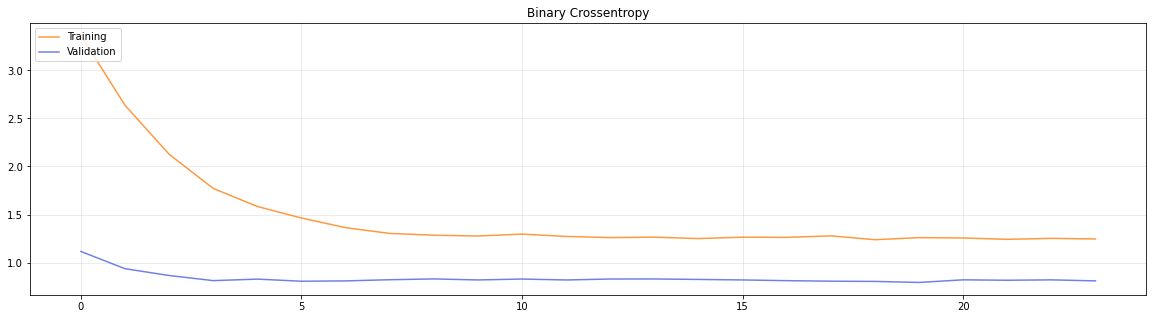

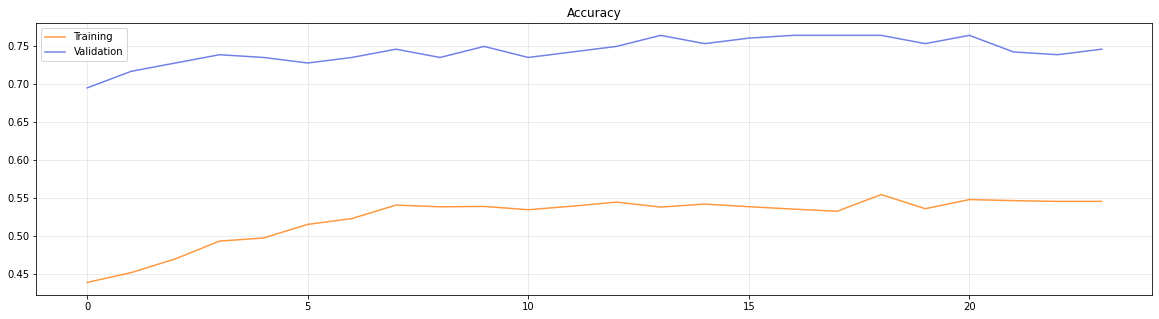

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save('tl_model')
zip_folder('tl_model')

In [ ]:
model = None

## Fine tuning

### Import the model

In [ ]:
if model is None:
  model = keras.models.load_model('tl_model')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_batch_normalization (Ba  (None, 1280)             5120      
 tchNormalization)                                               
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                           

### Set layers for training

In [ ]:
model.get_layer(base_model.name).trainable = True
num_layers = len(model.get_layer(base_model.name).layers)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", num_layers)

# Fine-tune from this layer onwards
fine_tune_at = len(model.get_layer(base_model.name).layers) - 30 #40 #30

print("Fine tuning from %d" % fine_tune_at)

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.get_layer(base_model.name).layers[:fine_tune_at]:
  layer.trainable = False

# Keep batch normalization layers frozen
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#transfer-learning-from-pretrained-weights
for layer in model.get_layer(base_model.name).layers:
  if isinstance(layer, layers.BatchNormalization):
      layer.trainable = False

model
model.summary()


Number of layers in the base model:  270
Fine tuning from 240
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_batch_normalization (Ba  (None, 1280)             5120      
 tchNormalization)                                               
                                                                 
 top_dropout (Dropout)       (None, 1280)              0       

### Train the model

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks = create_callbacks(patience=7))

Epoch 1/100
1000/1000 [==============================] - 29s 22ms/step - loss: 1.1650 - accuracy: 0.5830 - val_loss: 0.8061 - val_accuracy: 0.7491
Epoch 2/100
1000/1000 [==============================] - 20s 20ms/step - loss: 1.2082 - accuracy: 0.5608 - val_loss: 0.7799 - val_accuracy: 0.7600
Epoch 3/100
1000/1000 [==============================] - 20s 20ms/step - loss: 1.1849 - accuracy: 0.5675 - val_loss: 0.7720 - val_accuracy: 0.7600
Epoch 4/100
1000/1000 [==============================] - 20s 20ms/step - loss: 1.1758 - accuracy: 0.5701 - val_loss: 0.7576 - val_accuracy: 0.7709
Epoch 5/100
1000/1000 [==============================] - 20s 20ms/step - loss: 1.1450 - accuracy: 0.5860 - val_loss: 0.7477 - val_accuracy: 0.7745
Epoch 6/100
1000/1000 [==============================] - 20s 20ms/step - loss: 1.1289 - accuracy: 0.5899 - val_loss: 0.7439 - val_accuracy: 0.7564
Epoch 7/100
1000/1000 [==============================] - 20s 20ms/step - loss: 1.1144 - accuracy: 0.5984 - val_loss: 0

In [ ]:
model.get_layer(base_model.name).trainable = True
num_layers = len(model.get_layer(base_model.name).layers)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", num_layers)

# Fine-tune from this layer onwards
fine_tune_at = len(model.get_layer(base_model.name).layers) - 125

print("Fine tuning from %d" % fine_tune_at)

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.get_layer(base_model.name).layers[:fine_tune_at]:
  layer.trainable = False

# Keep batch normalization layers frozen
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#transfer-learning-from-pretrained-weights
for layer in model.get_layer(base_model.name).layers:
  if isinstance(layer, layers.BatchNormalization):
      layer.trainable = False

model
model.summary()


Number of layers in the base model:  270
Fine tuning from 145
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_batch_normalization (Ba  (None, 1280)             5120      
 tchNormalization)                                               
                                                                 
 top_dropout (Dropout)       (None, 1280)              0       

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks = create_callbacks(patience=7))

Epoch 1/100
1000/1000 [==============================] - 40s 31ms/step - loss: 1.0987 - accuracy: 0.6008 - val_loss: 0.6969 - val_accuracy: 0.7818
Epoch 2/100
1000/1000 [==============================] - 30s 30ms/step - loss: 1.0348 - accuracy: 0.6279 - val_loss: 0.6643 - val_accuracy: 0.7745
Epoch 3/100
1000/1000 [==============================] - 31s 31ms/step - loss: 0.9758 - accuracy: 0.6513 - val_loss: 0.6358 - val_accuracy: 0.7891
Epoch 4/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.9231 - accuracy: 0.6705 - val_loss: 0.6082 - val_accuracy: 0.8000
Epoch 5/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.8705 - accuracy: 0.6901 - val_loss: 0.5870 - val_accuracy: 0.8109
Epoch 6/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.8198 - accuracy: 0.7119 - val_loss: 0.5695 - val_accuracy: 0.8073
Epoch 7/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.7631 - accuracy: 0.7343 - val_loss: 0

### See results

In [ ]:
ft_res = pretty_print_results(model, train_ds, val_ds)

35/35 [==============================] - 1s 14ms/step - loss: 0.5155 - accuracy: 0.8436
0.4074 0.8764 0.5155 0.8436


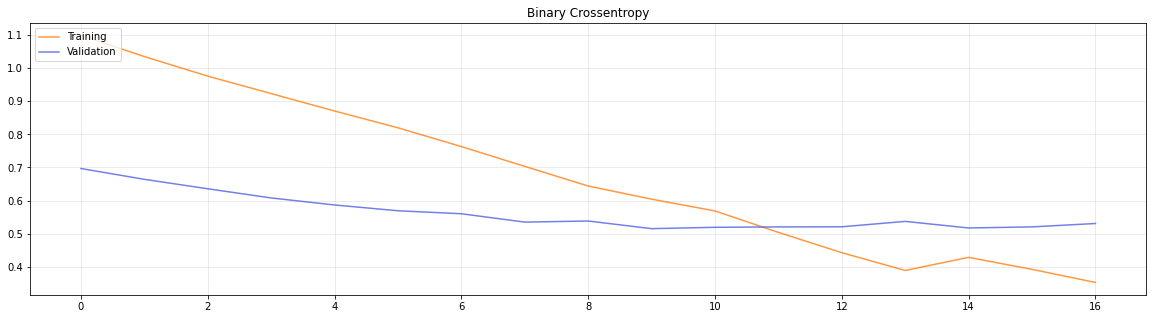

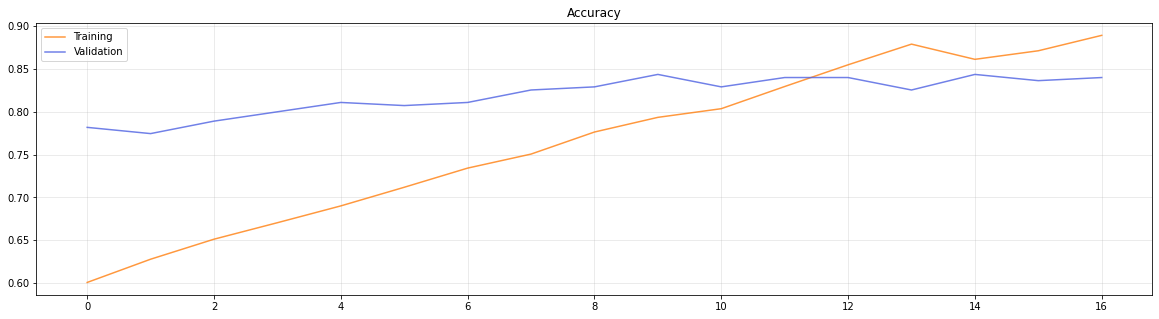

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save('ft_model')
zip_folder('ft_model')
del model
model = None

In [ ]:
tl_res
ft_res

([0.40741729736328125, 0.8763750195503235],
 [0.5154855847358704, 0.8436363339424133])